# Face Recognition using SVD

### Members:
- Ovadia Sutton
- Haider Ali

Import libraries

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle 
import os
from time import time

Declare the folder path in our local environment that has a folder of images. This path should be updated based on where the code is being run

In [2]:
folderpath = "/content/yaledatabase"

Read in files and store as list of images

In [3]:
imgfiles = os.listdir(folderpath)
imgfiles = sorted(imgfiles)
imgs = []
for i in imgfiles:
    img = (Image.open(folderpath + "/" + i))
    imgs.append(img)

We declare a function that converts an image defined by gradations of pixels in a (243, 320) matrix to a vector of dimension (77760, 1)

In [4]:
def img2vec(img):
    vec = np.asarray(img).reshape((77760, 1))
    return vec

We declare a function that reverses this process taking a (77760, 1) vector and converting it to a (243, 320) matrix and plotting the image. (We use the plt.imshow function over the PIL Image function as we do not need to scale the arrays)

In [5]:
def vec2img(vec):
    reshape = vec.reshape(243, 320)
    #img = Image.fromarray(reshape)
    img = plt.imshow(reshape)
    return img

We create a list of vectors from the images that we loaded from our database. 

In [6]:
vecs = []
for i in imgs:
    vecs.append(img2vec(i))

We plot a few of the images to ensure our data is loaded properly and our functions work as expected. 

In [ ]:
for i in range(15):
    vec2img(vecs[i])
    plt.show()

We collect the list of vectors into a datset of arrays. In total we have 165 vectors (images) each of length 77760 (total pixels). While a lot of the work considers the images as separate columns and the pixels as rows, for now it is easier to work with each image in a separate row. Later we will change accordingly. 

In [8]:
dataset = np.asarray(vecs).reshape(165, 77760)

We compute the "mean face" which returns the average pixel value of the images per pixel. We then plot this mean face. 

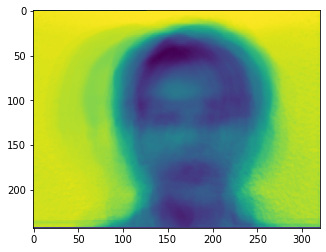

In [9]:
meanface = np.mean(dataset, axis = 0)
plt.imshow(meanface.reshape(243, 320))

We normalize the dataset by subtracting off the mean face allowing us to work with smaller numbers

In [10]:
normalized = dataset - meanface

The images in the folder contain 15 subjects with 11 pictures of each (totaling 165 images) in order. Here we divide our faces based on subjects so that faces[m][n] will be the nth image (1-11) of the mth subject(1-15). This allows us to track which vector belongs to which subject. 

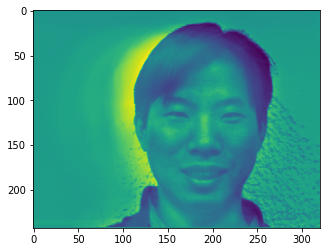

In [11]:
faces = np.split(normalized, 15, axis = 0)
vec2img(faces[3][2])

Now, we divide our dataset into a database that we will use and a set of query images in which we are interested in comparing the database and trying to figure out which subject it belongs to. For each subject, we shuffle the order of their images so we don't always get centerlight, glasses, happy in database and sleepy, wink, surpsrised in query set (otherwise this will skew our ability to compare the query set "sleepy" to the database if it has no "sleepy" faces). After shuffling the databse will contain 6 random images of each subject, and the query set will contain 5 random images of each subject. 

In [20]:
def create_set():
    normalized = dataset - meanface
    faces = np.split(normalized, 15, axis = 0)
    F = []
    Q = []
    for i in range(15):
        f = faces[i]
        shuffle(f)
        # np.split(f, [6,11])
        F.append([f[0], f[1], f[2], f[3], f[4], f[5]])
        Q.append([f[6], f[7], f[8], f[9], f[10]])
    return np.asarray(F), np.asarray(Q)   
F, Q = create_set() 

We define a function that considers a single face against the database. We iniate no match and a high minimum. We then compare the face to each image and get the norm. We set the minimum norm to the most likely match. 

In [21]:
def query(face, database):
    minim = 1000000000
    match = -1
    for i in range(15):
        for j in range(6):
            diff = np.linalg.norm(face - database[i][j])
            if diff < minim:
                minim = diff
                match = i
    return match         

We run the query function for each face in the query set and hold the value of the true subject. 

In [22]:
start = time()
def Basemodel():
    f = []
    m = []
    for i in range(15):
        for j in range(5):
            m.append(query(Q[i][j], F))
            f.append(i)
    return f, m
f, m = Basemodel()
print("Time for base model:", time()-start)

Time for base model: 0.7650704383850098


We compare the true identity of the subject to the match returned by the function in a dataframe. We count the values of when it was correct vs false. (Since we are shuffling the faces, the accuracy will be different everytime, depending on which faces are in the database and which are in the query set). Here we return 65/75 correct. 

In [23]:
matched = pd.DataFrame({'Face' : f, 'Match' : m, }, columns=['Face','Match'])
matched['T/F'] = (matched['Face']== matched['Match'])
matched['T/F'].value_counts()

True     63
False    12
Name: T/F, dtype: int64

In [24]:
print("Base Accuracy:", matched['T/F'].value_counts(normalize=True)[True])

Base Accuracy: 0.84


In [17]:
for i in range(10):
    F, Q = create_set()
    f, m = Basemodel()
    matched = pd.DataFrame({'Face' : f, 'Match' : m, }, columns=['Face','Match'])
    matched['T/F'] = (matched['Face']== matched['Match'])
    matched['T/F'].value_counts()
    print("Base Accuracy:", matched['T/F'].value_counts(normalize=True)[True])

Base Accuracy: 0.8666666666666667
Base Accuracy: 0.6933333333333334
Base Accuracy: 0.84
Base Accuracy: 0.7866666666666666
Base Accuracy: 0.8133333333333334
Base Accuracy: 0.8533333333333334
Base Accuracy: 0.7733333333333333
Base Accuracy: 0.8133333333333334
Base Accuracy: 0.84
Base Accuracy: 0.8533333333333334


We organize or database set into a matrix so we can use SVD to create a base face space. Here we are not using all the faces in the initial dataset, but the faces that we are using as our database. We think that this is often the more practical way to perform SVD as we will not always know about the data we are going to query when designing it. (Although we do think the more faces used, the more helpful SVD will be and therefore maybe more accurate (especially since the actual query vectors are being included in the decomposition which is creating the base space). 

In [18]:
Fset2d = F.reshape(90, 77760).T
Fset2d.shape

(77760, 90)

We use the SVD function on the Fset matix to get the U, Sigma diagnol entries, and V matrices. 

In [19]:
U, s, Vt = np.linalg.svd(Fset2d, full_matrices = False)
Sig = np.diag(s)
UT = U.T

We plot the first 50 base faces and observe that the last plot offers very little information. This will help us in determining p = how many base faces we will use. We know for sure that after 50 faces the remaining vectors do not offer much information. (Again this will vary based on the shuffle of which images are in F or Q, it will also vary depending on how many images are in each and whether we run SVD on whole original datset or just F set). So at very least we know we do not have to use more than 50 base face vectors to createour base face. 

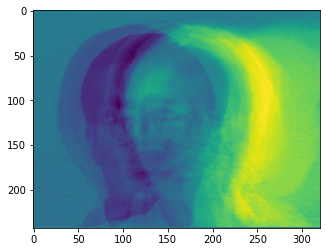

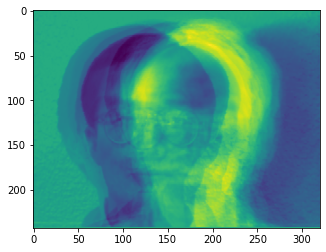

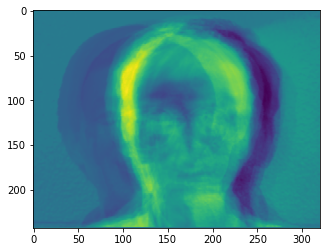

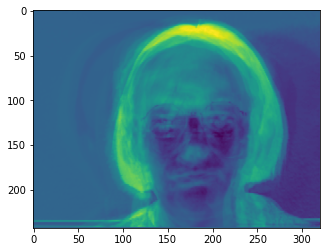

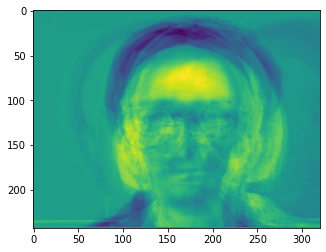

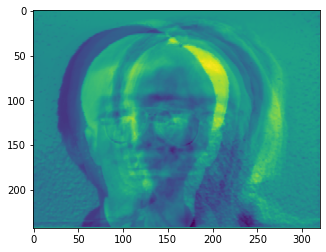

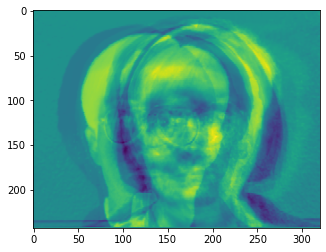

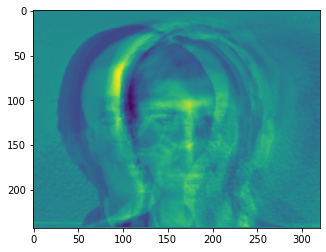

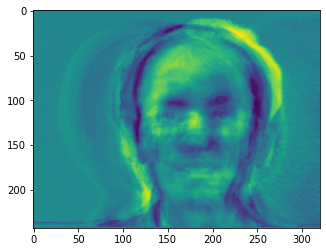

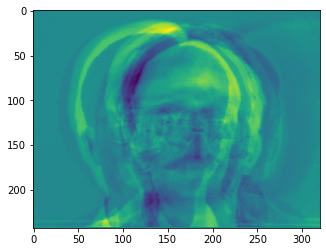

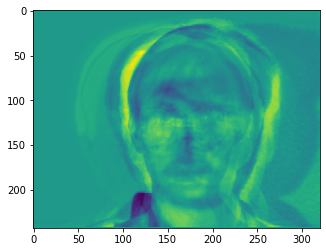

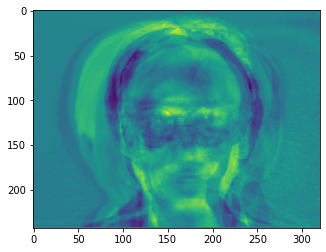

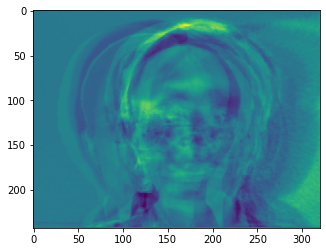

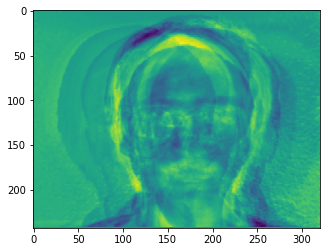

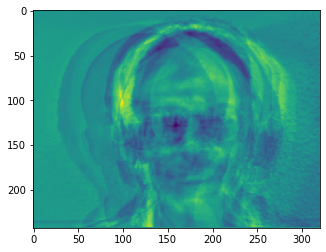

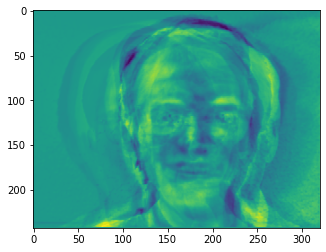

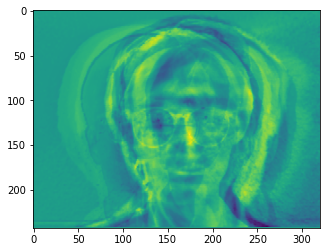

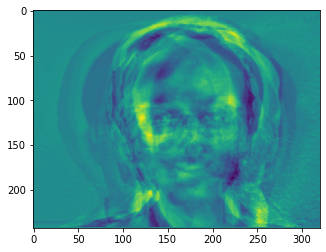

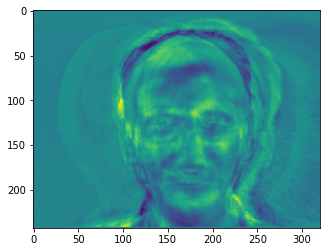

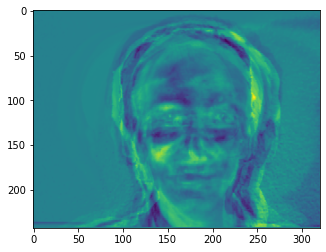

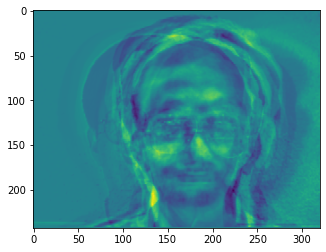

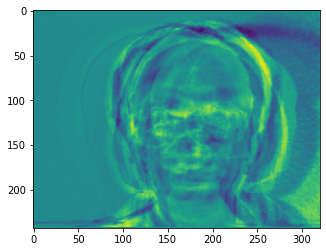

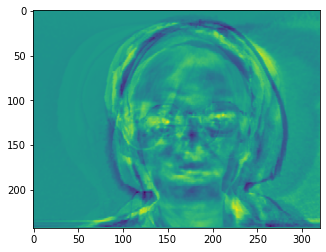

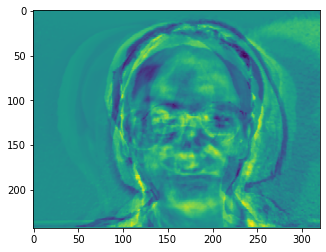

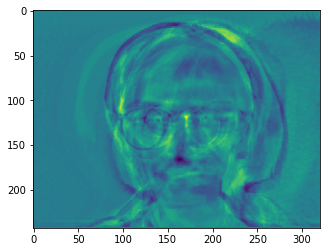

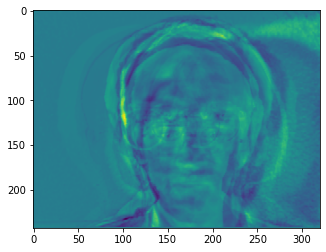

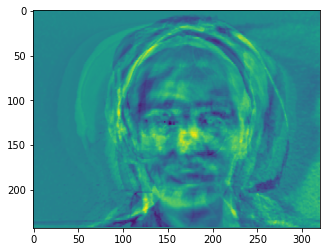

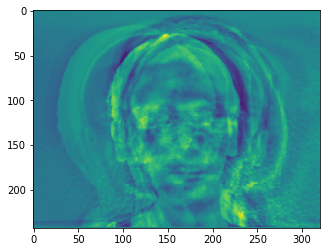

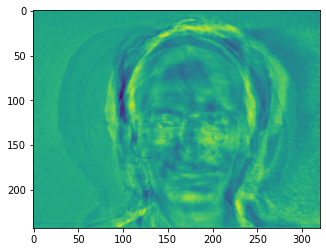

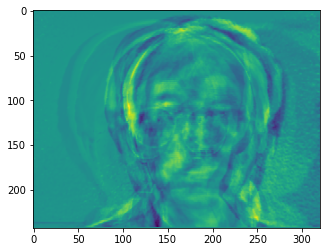

In [25]:
for i in range(30):
    vec2img(UT[i])
    plt.show()

Choosing p (how many of the first k/n vectors we will use to create our base space is difficult). At the very least, we think we need at least one vector per person to mantain identities. At most, once the plotted images go blank (vector values are close to 0 so this is r = rank of reuced U) the extra vectors do not add much information. We have distilled our range between 15-50 vector. We plot p against our $\sigma_{ii}$ entries which gives weights to each vector in U. As these weights decrease, their corresponding column becomes less significant, so we can consider setting $ p = k$ where $ \sigma_{kk} < error$. We plot the values of $\sigma$ against $k$ and watch the decline.

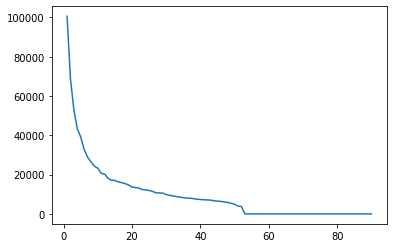

In [26]:
x = np.arange(1, 91, 1)
plt.plot(x, s)

We test possible values of p at our min 15, max 50, and some values in between based on our reading of the graph. 

In [27]:
p = [15, 20, 30, 50] 

We look to project our face vectors into the base face space. We select the the subspace based on p. (Again we transpose as we are interested in using rows).  

In [28]:
UTsub = UT[0 : p[0]] # choose first p rows of transpose. ie first p columns of U

We use the transpose of the subset of U as our projection matrix as mentioned in the paper. We will multiply UTsub by each vector to project into base face space. 

Project each vector onto our base space while retaining subject identity

In [29]:
F2 = [[0 for i in range(6)] for j in range(15)]
Q2 = [[0 for i in range(5)] for j in range(15)]
for i in range(15):
    for j in range(6):
        F2[i][j] = np.matmul(UTsub, F[i][j])#projection 
    for k in range(5):
        Q2[i][k] = np.matmul(UTsub, Q[i][k])

Test again using our query function and observe results. 

In [30]:
def SVD_model():
    f2 = []
    m2 = []
    for i in range(15):
        for j in range(5):
            m2.append(query(Q2[i][j], F2))
            f2.append(i)
    return f2, m2
start = time()
f2, m2 = SVD_model()
print("Time for SVD model:", time()-start)

Time for SVD model: 0.036542415618896484


In [31]:
matched2 = pd.DataFrame({'Face' : f2, 'Match' : m2, }, columns=['Face','Match'])
matched2['T/F'] = (matched2['Face']== matched2['Match'])
print("SVD accuracy:", matched2['T/F'].value_counts(normalize=True)[True])

SVD accuracy: 0.7866666666666666


We get similar results as without SVD.

In [32]:
pvals = [10, 20, 30,  50]
svd_acc = []
base_acc = []
base_time = []
svd_time = [] 
for p in pvals:
    F, Q = create_set()
    start = time()
    f, m = Basemodel()
    base_time.append(time()-start)
    matched = pd.DataFrame({'Face' : f, 'Match' : m, }, columns=['Face','Match'])
    matched['T/F'] = (matched['Face']== matched['Match'])
    base_acc.append(matched['T/F'].value_counts(normalize=True)[True] )
    Fset2d = F.reshape(90, 77760).T
    U, s, Vt = np.linalg.svd(Fset2d, full_matrices = False)
    UTsub = U.T[: p] 
    F2 = [[0 for i in range(6)] for j in range(15)]
    Q2 = [[0 for i in range(5)] for j in range(15)]
    for i in range(15):
        for j in range(6):
            F2[i][j] = np.matmul(UTsub, F[i][j])#projection 
        for k in range(5):
            Q2[i][k] = np.matmul(UTsub, Q[i][k])
    start = time()
    f2, m2 = SVD_model()
    svd_time.append(time()-start)
    matched = pd.DataFrame({'Face' : f2, 'Match' : m2, }, columns=['Face','Match'])
    matched['T/F'] = (matched['Face']== matched['Match'])
    svd_acc.append(matched['T/F'].value_counts(normalize=True)[True])
    
pd.DataFrame({"P":pvals, "Base Accuracy":base_acc, "SVD Accuracy":svd_acc,
              "Base time":base_time, "SVD time":svd_time})

,P,Base Accuracy,SVD Accuracy,Base time,SVD time
0,10,0.826667,0.746667,0.749395,0.052465
1,20,0.866667,0.840000,0.685101,0.045215
2,30,0.880000,0.840000,0.718541,0.044616
3,50,0.933333,0.933333,0.693553,0.044818


# <center> Extra credit questions <center>

We built a method for SVD from scratch but we were unable to calculate it for the images as they're non-square matrices.

In [108]:
# Calculating Eigenvalues 
mat = np.array([[1, 2],  # Defining a matrix
                [3, 4]])
LA = np.linalg

def eigen_qr(A, iterations=90000):  # Using QR facotrization to calculate Eigenvalues
    eig = np.copy(A)
    n = A.shape[0]
    QQ = np.eye(n) # Creating an Identity matrix
    for k in range(iterations):
        Q, R = np.linalg.qr(eig) # Decomposition in QR
        eig = R @ Q
        QQ = QQ @ Q
    return eig, QQ

eigvals, qq = eigen_qr(mat)
eigvals = [eigvals[0][0], -eigvals[1][1]]
print("Eigen values:", eigvals)

Eigen values: [5.372281323269015, 0.37228132326901375]


In [115]:
# Calculating Eigenvectors 
def power_itr(mat, x0, domeigvect, itr, rq=True):  # Using Power iteration to find vectors
    """
    mat: Matrix of which you need to find Eigen values of.
    x0: Initial vector.
    itr: Number of Iterations.
    rq: If user wnats to solve it using Rayleigh Quotient iteration.
    """
    if rq:
        for i in range(itr):
            eigvec = x0/LA.norm(x0, ord=2)
            x0 = np.array(mat)@ eigvec
            eigval = (eigvec.T@mat)@x0
    else:
        for i in range(itr):
            eigvec = x0/LA.norm(x0, ord=2)
            x0 = np.array(mat) @ eigvec
            eigval = eigvec.T@ x0
            eigvecnow = x0/LA.norm(x0, ord=2)

    return -eigvec

u = power_itr(mat.T@mat, [1, 1], [10, 10],10, False)
v = power_itr(mat@mat.T, [1, 1], [10, 10],10, False)
sigma = np.eye(len(eigvals))
np.fill_diagonal(sigma, eigvals)
sigma # Sigma

array([[5.37228132, 0.        ],
       [0.        , 0.37228132]])

In [116]:
U = np.zeros(len(u)*2).reshape(len(u), len(u))
U = np.repeat(u, 2).reshape(2, 2)
U[0, 1], U[1, 1] = U[1, 1], -U[0, 1]
U

array([[-0.57604844, -0.81741556],
       [-0.81741556,  0.57604844]])

In [118]:
V = np.zeros(len(v)*2).reshape(len(v), len(v))
V = np.repeat(v, 2).reshape(2, 2)
V[0, 1], V[1, 1] = V[1, 1], V[0, 1]
V[1, 0] *= -1
V

array([[-0.40455358, -0.9145143 ],
       [ 0.9145143 , -0.40455358]])

In [119]:
print("Our result")
print("U:",U)
print("Sigma:", sigma)
print("V:", V)
print("U@Sigma@V:", U@sigma@V)

Our result
U: [[-0.57604844 -0.81741556]
 [-0.81741556  0.57604844]]
Sigma: [[5.37228132 0.        ]
 [0.         0.37228132]]
V: [[-0.40455358 -0.9145143 ]
 [ 0.9145143  -0.40455358]]
U@Sigma@V: [[0.97367514 2.95325125]
 [1.97267058 3.92922824]]


In [120]:
U, sigma, V = LA.svd(mat)
print("Actual result")
print("U:",U)
print("Sigma:", sigma)
print("V:", V)
print("U@Sigma@V:", U@sigma@V)

array([-2.49789853,  4.87447463])